In [30]:
import pandas as pd
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import gzip
import pickle
import seaborn as sns

In [2]:
train_data = pd.read_parquet(
    "../data/submission/processed/chrome/08_12_2022/calibration_set_featurized_response_BE.parquet.gzip"
)

test_data = pd.read_parquet(
    "../data/submission/processed/chrome/08_12_2022/test_set_featurized_response_BE.parquet.gzip"
)

In [62]:
def plot_calibration_curves(clf_list, clf_list_calibrated, X_test, y_test):
    fig = plt.figure(figsize=(16, 20))
    gs = GridSpec(8, 4, figure=fig)  
    
    sns.set(style="whitegrid", color_codes=True)
    plt.rcdefaults()
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    # "pdf.fonttype": 3,
    "text.latex.preamble": r"\usepackage[T1]{fontenc}",
    })
    colors = plt.get_cmap('tab20')

    classifier_colors = {name: colors(i % 20) for i, (_, name) in enumerate(clf_list)}

    # Row 1: Calibration curves for uncalibrated classifiers (spanning all 4 columns)
    ax_uncalibrated_curve = fig.add_subplot(gs[:2, :])
    uncalibrated_displays = {}
    markers = ["^", "v", "s", "o", "D", "*", "P", "X", "d", "|", "_"]
    
    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=f"Uncalibrated {name}",
            ax=ax_uncalibrated_curve,
            color=classifier_colors[name],  # Same color mapping
            marker=markers[i % len(markers)]
        )
        uncalibrated_displays[name] = display

    # Style the uncalibrated calibration plot
    ax_uncalibrated_curve.grid(True, linestyle='-', linewidth=0.5)
    ax_uncalibrated_curve.set_title("Uncalibrated Calibration plots", fontsize=20)
    ax_uncalibrated_curve.set_xlabel("Mean predicted probability (Positive class: 1)", fontsize=14)
    ax_uncalibrated_curve.set_ylabel("Fraction of positives (Positive class: 1)", fontsize=14)
    ax_uncalibrated_curve.tick_params(axis='both', labelsize=12)
    ax_uncalibrated_curve.legend(loc='lower right', fontsize=12, title="Classifiers")

    # Row 2: Calibration curves for calibrated classifiers (spanning all 4 columns)
    ax_calibration_curve = fig.add_subplot(gs[2:4, :])
    calibration_displays = {}

    for i, (clf, name) in enumerate(clf_list_calibrated):
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=classifier_colors[name],
            marker=markers[i % len(markers)]
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid(True, linestyle='-', linewidth=0.5)
    ax_calibration_curve.set_title("Calibration plots", fontsize=20)
    ax_calibration_curve.legend(loc='lower right', fontsize=12, title="Classifiers")
    ax_calibration_curve.set_xlabel("Mean predicted probability (Positive class: 1)", fontsize=14)
    ax_calibration_curve.set_ylabel("Fraction of positives (Positive class: 1)", fontsize=14)
    ax_calibration_curve.tick_params(axis='both', labelsize=12)
    
    # Add histograms
    for i, (_, name) in enumerate(clf_list_calibrated):
        ax = fig.add_subplot(gs[4 + i // 4, i % 4])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=classifier_colors[name],
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)
        ax.grid(True, linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.savefig('calibration_plot.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

    plt.show()

In [4]:
def calibrate_and_save_classifiers(classifier_list, X_cal, y_cal):
    """
    Calibrate classifiers and save them to a list.

    :param classifier_list: List of (classifier, name) tuples
    :param X_cal: Calibration set features
    :param y_cal: Calibration set labels
    :return: List of calibrated classifiers
    """
    calibrated_classifiers = []

    for clf, name in classifier_list:
        print(clf, name)
        # Calibrate the classifier
        calibrated_clf = CalibratedClassifierCV(estimator=clf, method='isotonic', cv='prefit', n_jobs=-1)
        calibrated_clf.fit(X_cal, y_cal)

        # Save the calibrated classifier to the list
        calibrated_classifiers.append((calibrated_clf, name))

    return calibrated_classifiers

In [5]:
filename = f"LightGBM_BE.sav.gz"
filename1 = f"Random_Forest_BE.sav.gz"
filename2 = f"Logistic_Regression_BE.sav.gz"
filename3 = f"Hist_GB_BE.sav.gz"
filename4 = f"Ada_Boost_BE.sav.gz"
filename5 = f"Decision_Tree_BE.sav.gz"
filename6 = f"Extra_Trees_Classifier_BE.sav.gz"
filename7 = f"XGBoost_BE.sav.gz"
filename8 = f"Gradient_Boosting_BE.sav.gz"
filename9 = f"Gaussian_NB_BE.sav.gz"

In [14]:
with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename}", "rb") as f:
    lgbm = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename1}", "rb") as f:
    rfc = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename2}", "rb") as f:
    lr = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename3}", "rb") as f:
    hgb = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename4}", "rb") as f:
    ada = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename5}", "rb") as f:
    dt = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename6}", "rb") as f:
    et = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename7}", "rb") as f:
    xgb = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename8}", "rb") as f:
    gb = pickle.load(f)

with gzip.GzipFile(f"../models/classifiers_submission/chrome/08_12_2022/response/{filename9}", "rb") as f:
    gnb = pickle.load(f)

In [15]:
clf_list = [
    (lr, "LR"),
    (gnb, "GNB"),
    (dt, "DT"),
    (rfc, "RF"),
    (et, "ET"),
    (ada, "AdaBoost"),
    (gb, "GBM"),
    (lgbm, "LightGBM"),
    (hgb, "HistGB"),
    (xgb, "XGBoost"),
]

["LR", "GNB", "DT", "RF", "ET", "AdaBoost", "GBM", "LightGBM", "HistGB", "XGBoost"]

In [8]:
for clf, name in clf_list:
    print(f"{name}: {hasattr(clf, 'classes_')}")

LR: True
GNB: True
DT: True
RF: True
ET: True
AdaBoost: True
GBM: True
LightGBM: True
HistGB: True
XGBoost: True


In [18]:
X_train, y_train = train_data.iloc[:, 2:-2], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, 2:-2], test_data[["tracker"]]

In [19]:
%%time
calibrated_clf_list = calibrate_and_save_classifiers(clf_list, X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=10,
                   solver='newton-cholesky') LR
GaussianNB() GNB
DecisionTreeClassifier(random_state=10) DT
RandomForestClassifier(max_features=None, n_jobs=-1, random_state=10) RF
ExtraTreesClassifier(n_jobs=-1, random_state=10) ET
AdaBoostClassifier(random_state=10) AdaBoost
GradientBoostingClassifier(random_state=10) GBM
LGBMClassifier(n_jobs=-1, random_state=10) LightGBM
HistGradientBoostingClassifier(random_state=10) HistGB
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, ma

/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take preceden

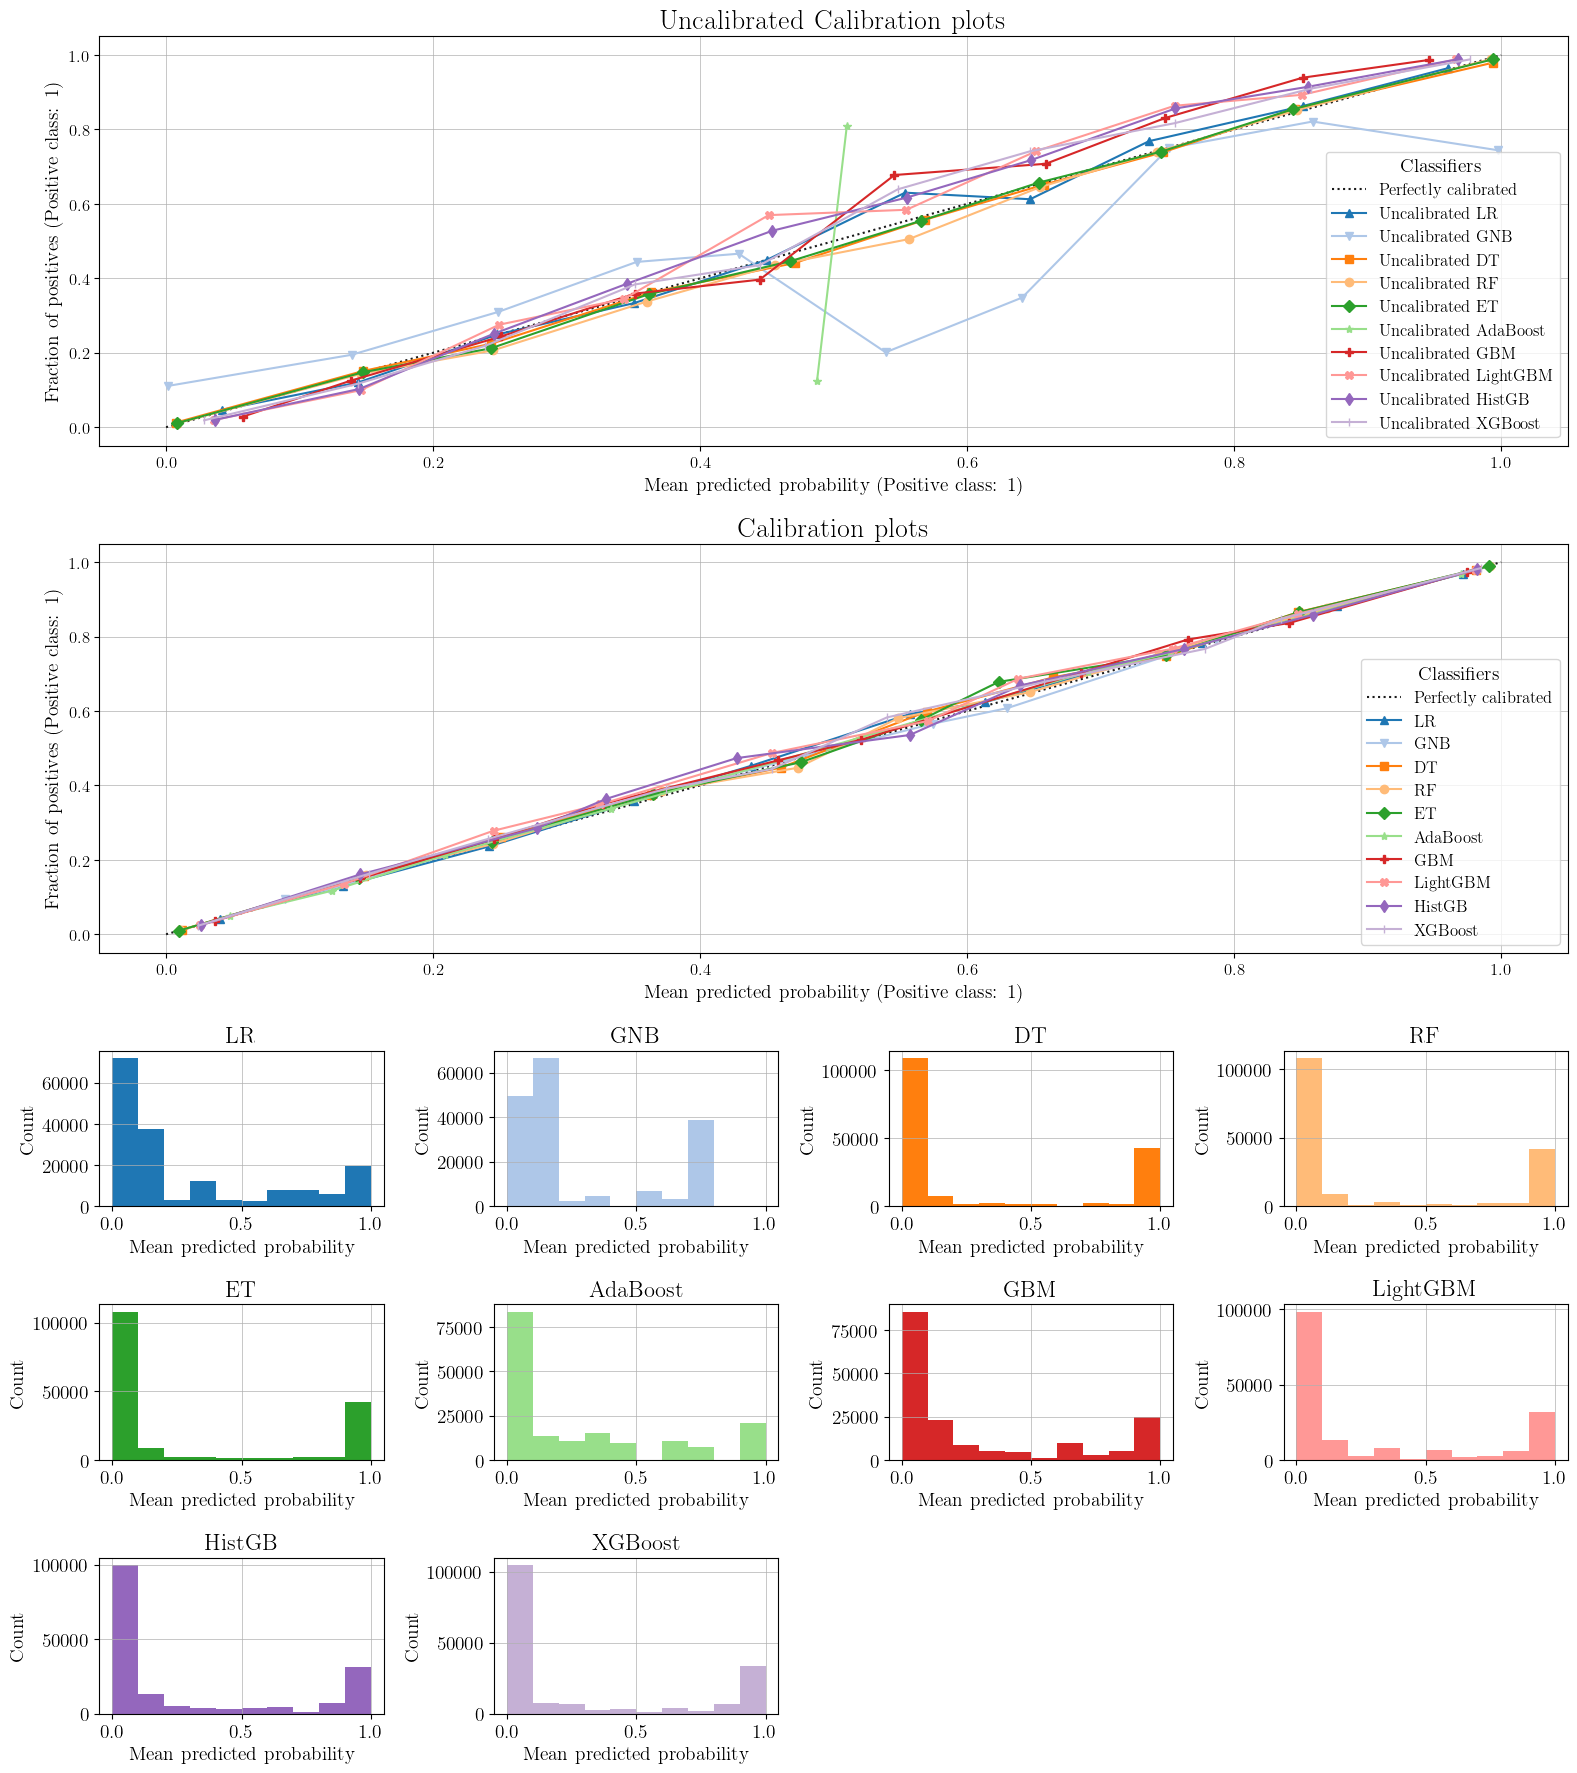

In [63]:
plot_calibration_curves(clf_list, calibrated_clf_list, X_test, y_test)